In [2]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

figsize=(14, 4)

random_state = 42   

from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error

from utils.data_visualizator import plot_confusion_matrix

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV

from utils import DataAggregator
import pandas as pd

from tqdm import tqdm

# Regression
As we saw from the previous notebook, the classifiers struggles when it comes to predicting all three classes. Actually, only the KNN-classifier predicts a somewhat sensible outcome distribution. Lets have a look at how we possibly can imporve this using regression on the goal differences.

In [3]:
data_aggregator = DataAggregator()
df = data_aggregator.get_data(["E0"])
df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A
0,E0,13/08/05,Aston Villa,Bolton,2,2,D,2,2,D,...,16,7,8,0,2,0,0,2.30,3.25,3.00
1,E0,13/08/05,Everton,Man United,0,2,A,0,1,A,...,14,8,6,3,1,0,0,5.00,3.40,1.72
2,E0,13/08/05,Fulham,Birmingham,0,0,D,0,0,D,...,13,6,6,1,2,0,0,2.37,3.25,2.87
3,E0,13/08/05,Man City,West Brom,0,0,D,0,0,D,...,11,3,6,2,3,0,0,1.72,3.40,5.00
4,E0,13/08/05,Middlesbrough,Liverpool,0,0,D,0,0,D,...,11,5,0,2,3,1,0,2.87,3.20,2.40


In [4]:
df = data_aggregator.create_gd_feature(df)
df = data_aggregator.format_date(df, "Date")
df = data_aggregator.encode_result(df,
                        mapping={"H": 1, "D": 0, "A": -1}, 
                        result_column="FTR")
df = data_aggregator.create_form_data(df, form_window=3)
df.drop(columns=["Div", "FTHG", "FTAG", "HTHG", "HTAG", "HTR", "Referee", "HS", "AS", "HST", "AST", "HF", "AF", "HC","AC","HY","AY","HR","AR"], inplace=True)

In [5]:
df.columns

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTR', 'B365H', 'B365D', 'B365A', 'GD',
       'Year', 'Month', 'Day', 'DayOfWeek', 'HomeTeamPPG', 'AwayTeamPPG',
       'HomeTeamWinForm', 'AwayTeamWinForm', 'HomeTeamGoalForm',
       'AwayTeamGoalForm', 'HomeTeamGoalAgainstForm',
       'AwayTeamGoalAgainstForm'],
      dtype='object')

In [6]:
df.head()

,Date,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,GD,Year,Month,Day,DayOfWeek,HomeTeamPPG,AwayTeamPPG,HomeTeamWinForm,AwayTeamWinForm,HomeTeamGoalForm,AwayTeamGoalForm,HomeTeamGoalAgainstForm,AwayTeamGoalAgainstForm
0,2002-08-17,Blackburn,Sunderland,0,1.727,3.25,4.333,0,2002,8,17,5,1.518717,0.730370,0.105169,0.431852,1.356506,0.876296,1.157754,1.746667
1,2002-08-17,Southampton,Middlesbrough,0,2.250,3.25,2.750,0,2002,8,17,5,1.372035,0.800895,0.015605,0.374720,1.378277,0.838926,1.297753,1.498881
2,2002-08-17,Man United,West Brom,1,1.200,5.00,12.000,1,2002,8,17,5,2.243437,0.801913,0.554495,0.365437,2.032617,0.869536,0.813842,1.650956
3,2002-08-17,Charlton,Chelsea,-1,2.800,3.25,2.200,-1,2002,8,17,5,1.467391,1.789181,0.057971,-0.261337,1.335145,1.611774,1.342391,1.054495
4,2002-08-17,Fulham,Bolton,1,1.727,3.25,4.333,3,2002,8,17,5,1.490710,0.953654,0.062842,0.293226,1.378689,1.007130,1.313115,1.687166


Finally, lets also one-hot encode each team for ease of use for the model.

In [7]:
df = data_aggregator.one_hot_encode_teams(df, "HomeTeam", "AwayTeam")

Lets split the data into training samples and perform regression to try and create accurate predictions.

In [8]:
target = "GD"
df_train = df[df["Date"] < "2023-07-01"]
df_test = df[df["Date"] >= "2023-07-01"]
df_test = df_test[df_test["Date"] < "2024-07-01"]

X_train = df_train.drop(columns=[target, "Date", "FTR"])
y_train = df_train[target]
X_test = df_test.drop(columns=[target, "Date", "FTR"])
y_test = df_test[target]

Lets also do some more preprossessing of the data by scaling the features.

In [9]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
regr = RandomForestRegressor(n_estimators=500,
                             max_depth=30,
                             random_state=random_state)

In [11]:
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, n_estimators=500, random_state=42)

In [12]:
predicitions = regr.predict(X_test)

Now we need a way to turn the predicted goal difference in the game to a result.

In [13]:
def map_result(predicitions):
    return [1 if p >= 1 else -1 if p <= -1 else 0 for p in map(round, predicitions)]

In [14]:
mapped_predictions = map_result(predicitions)

In [15]:
predicitions_df = pd.concat([df_test[[target, "FTR", "B365H", "B365D", "B365A"]].reset_index(drop=True), pd.Series(predicitions, name="PredictedGD"), pd.Series(mapped_predictions, name="PredictedOutcome")], axis=1)
predicitions_df.head()

,GD,FTR,B365H,B365D,B365A,PredictedGD,PredictedOutcome
0,-3,-1,8.00,5.5,1.33,-1.140300,-1
1,3,1,1.33,5.5,9.00,0.147883,0
2,-1,-1,2.20,3.4,3.30,0.180410,0
3,1,1,1.18,7.0,15.00,2.194701,1
4,0,0,2.70,3.4,2.55,-0.122635,0


In [16]:
accuracy, won = data_aggregator.calculate_accuracy(predicitions_df, "FTR", "PredictedOutcome")

In [17]:
print(f"""The accuracy of the model is {accuracy:.2%}
The accuracy of the model is {accuracy*len(predicitions_df):.0f} out of {len(predicitions_df)} games.
""")
print(f"With this model, the expected return on value would be {won:.2f}€")

The accuracy of the model is 53.95%
The accuracy of the model is 205 out of 380 games.

With this model, the expected return on value would be 7147.90€


In [18]:
print("Classification report")
print(classification_report(predicitions_df["FTR"], predicitions_df["PredictedOutcome"]))

Classification report
              precision    recall  f1-score   support

          -1       0.66      0.50      0.57       123
           0       0.28      0.44      0.34        82
           1       0.68      0.62      0.64       175

    accuracy                           0.54       380
   macro avg       0.54      0.52      0.52       380
weighted avg       0.59      0.54      0.55       380



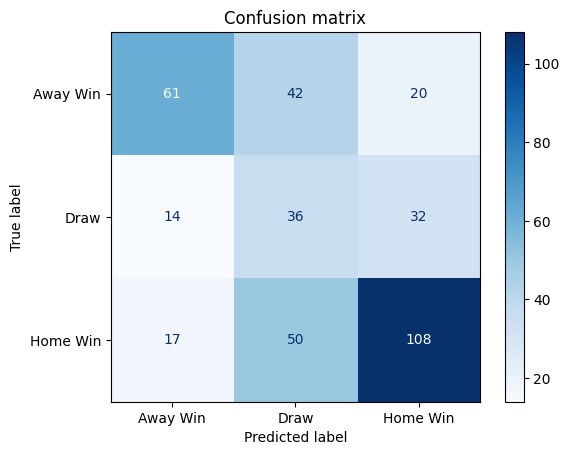

In [19]:
cm = confusion_matrix(predicitions_df["FTR"], predicitions_df["PredictedOutcome"])
plot_confusion_matrix(cm, ["Away Win", "Draw", "Home Win"])

In [20]:
data_aggregator.save_metrics("RandomForestRegressor", accuracy, won)

What if we again filter out the draws, and have a look at how the model performs when only prediciting wins and losses.

In [21]:
df = data_aggregator.get_data(["E0"])
df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A
0,E0,13/08/05,Aston Villa,Bolton,2,2,D,2,2,D,...,16,7,8,0,2,0,0,2.30,3.25,3.00
1,E0,13/08/05,Everton,Man United,0,2,A,0,1,A,...,14,8,6,3,1,0,0,5.00,3.40,1.72
2,E0,13/08/05,Fulham,Birmingham,0,0,D,0,0,D,...,13,6,6,1,2,0,0,2.37,3.25,2.87
3,E0,13/08/05,Man City,West Brom,0,0,D,0,0,D,...,11,3,6,2,3,0,0,1.72,3.40,5.00
4,E0,13/08/05,Middlesbrough,Liverpool,0,0,D,0,0,D,...,11,5,0,2,3,1,0,2.87,3.20,2.40


In [ ]:
df = data_aggregator.create_gd_feature(df)
df = data_aggregator.format_date(df, "Date")
df = data_aggregator.encode_result(df,
                        mapping={"H": 1, "D": 0, "A": -1}, 
                        result_column="FTR")
df = data_aggregator.create_form_data(df, form_window=3)
df = data_aggregator.one_hot_encode_teams(df, "HomeTeam", "AwayTeam")
df.drop(columns=["Div", "FTHG", "FTAG", "HTHG", "HTAG", "HTR", "Referee", "HS", "AS", "HST", "AST", "HF", "AF", "HC","AC","HY","AY","HR","AR"], inplace=True)

In [23]:
target = "GD"
df_train = df[df["Date"] < "2023-07-01"]
df_test = df[df["Date"] >= "2023-07-01"]
df_test = df_test[df_test["Date"] < "2024-07-01"]

X_train = df_train.drop(columns=[target, "Date", "FTR"])
y_train = df_train[target]
X_test = df_test.drop(columns=[target, "Date", "FTR"])
y_test = df_test[target]

In [24]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
regr = RandomForestRegressor(n_estimators=500,
                             max_depth=30,
                             random_state=random_state)

In [26]:
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, n_estimators=500, random_state=42)

In [27]:
predicitions = regr.predict(X_test)

In [28]:
mapped_predictions = map_result(predicitions)

In [29]:
import numpy as np
mask = np.array(mapped_predictions) != 0

predicitions_df = pd.concat([df_test[[target, "FTR", "B365H", "B365D", "B365A"]].reset_index(drop=True), pd.Series(predicitions, name="PredictedGD"), pd.Series(mapped_predictions, name="PredictedOutcome")], axis=1)
predicitions_df = predicitions_df[mask]

predicitions_df.head()

,GD,FTR,B365H,B365D,B365A,PredictedGD,PredictedOutcome
0,-3,-1,8.00,5.50,1.33,-1.140300,-1
3,1,1,1.18,7.00,15.00,2.194701,1
5,4,1,1.75,3.75,4.60,1.122132,1
6,-1,-1,3.00,3.30,2.38,-0.571566,-1
9,1,1,1.33,5.50,9.00,1.569149,1


In [30]:
accuracy, won = data_aggregator.calculate_accuracy(predicitions_df, "FTR", "PredictedOutcome")

In [31]:
print(f"""The accuracy of the model is {accuracy:.2%}
The accuracy of the model is {accuracy*len(predicitions_df):.0f} out of {len(predicitions_df)} games.
""")
print(f"With this model, the expected return on value would be {won:.2f}€")

The accuracy of the model is 67.06%
The accuracy of the model is 169 out of 252 games.

With this model, the expected return on value would be 7453.00€


In [32]:
print("Classification report")
print(classification_report(predicitions_df["FTR"], predicitions_df["PredictedOutcome"]))

Classification report
              precision    recall  f1-score   support

          -1       0.66      0.75      0.71        81
           0       0.00      0.00      0.00        46
           1       0.68      0.86      0.76       125

    accuracy                           0.67       252
   macro avg       0.45      0.54      0.49       252
weighted avg       0.55      0.67      0.60       252



/Users/andreasmarken/Desktop/Unibo/AI in Industry/project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andreasmarken/Desktop/Unibo/AI in Industry/project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andreasmarken/Desktop/Unibo/AI in Industry/project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

Again, we see a significant increase in performance. The model is specifically good at prediciting home wins, and is also pretty decent at predicting the away wins as well.

In [33]:
data_aggregator.save_metrics("RandomForestRegressor (no draws)", accuracy, won)